In [8]:
cd("/home/gadus/programing-projects/julia-projects/ThreeStageModel")
using DataFrames, JLD2, LambdaFn, Plots, StatsBase, StatsPlots



selection_coefficients::Vector{Float64} = [0.1,0.2,0.3]
cline_widths::Vector{Float64} = [10,15,20]


carring_capacity::Int64 = 200
reproductive_rate::Float64 = 1.1
number_of_patches::Int64 = 300
individuals_per_patch::Int64 = 100
generations = 10000

cache = (vars = Vector{Float64}(undef, 2),
         genotype_counts  = Array{Int16}(undef, 100, 100 + ceil(Int, (generations - 100)/10), number_of_patches, 5, 3),
         population_sizes = Array{Int16}(undef, 100, 100 + ceil(Int, (generations - 100)/10), number_of_patches, 5),
         genotype_frequencies = Array{Float32}(undef, 100, 100 + ceil(Int, (generations - 100)/10), number_of_patches, 5, 3),
         fitnesses = Array{Float32}(undef,100, 100 + ceil(Int, (generations - 100)/10), number_of_patches, 5))

#genotype_counts = Array{Int16}(undef, generations, number_of_patches, 5, 3, 3, 3)
function load_results!(cache, selection_coefficients, cline_widths)
    if cache.vars != [selection_coefficients, cline_widths]
        cache.vars .= [selection_coefficients, cline_widths]
        cache.genotype_counts .= load_object("results/genotype_counts_s_$(selection_coefficients)_cw_$(cline_widths)_r_1.1.jld2")
        cache.population_sizes .= sum.(eachslice(cache.genotype_counts, dims = (1,2,3,4)))
        cache.genotype_frequencies .= cache.genotype_counts ./ cache.population_sizes
        cache.fitnesses[:, :, 1:150,: ]   .= cache.genotype_frequencies[:,:,1:150,:,1]                                     .+ cache.genotype_frequencies[:,:,1:150  ,:,2] .* (1 - selection_coefficients) .+ cache.genotype_frequencies[:,:,  1:150,:,3] .* (1 - 2*selection_coefficients)
        cache.fitnesses[:, :, 151:300,: ] .= cache.genotype_frequencies[:,:,151:300,:,1] .* (1 - 2*selection_coefficients) .+ cache.genotype_frequencies[:,:,151:300,:,2] .* (1 - selection_coefficients) .+ cache.genotype_frequencies[:,:,151:300,:,3]
    end
    return nothing
end

#all(0.001 .> (cache.genotype_frequencies[:,:,:,:,1] .+ cache.genotype_frequencies[:,:,:,:,2] .+ cache.genotype_frequencies[:,:,:,:,3]) .- 1.0)

load_results! (generic function with 1 method)

In [ ]:


function calc_cline_width(cache, selection_coefficient, cline_width)
    load_results!(cache, selection_coefficient, cline_width)
    allele_freqs = cache.genotype_frequencies[:,end,:,:,3] .+ cache.genotype_frequencies[:,end,:,:,2] .* 0.5
    function calc_cline_width_one_run(mean_allele_freqs_one_run)
        min_allele_freq = mean(mean_allele_freqs_one_run[1:30])
        max_allele_freq = mean(mean_allele_freqs_one_run[end-29:end])
        min_cline = min_allele_freq + (max_allele_freq - min_allele_freq) * 0.2
        max_cline = max_allele_freq - (max_allele_freq - min_allele_freq) * 0.2
    
        cline_lims = (findfirst((x -> x - max_cline > 0.01),mean_allele_freqs_one_run ), findfirst((x -> x - min_cline > 0.01),mean_allele_freqs_one_run ))
        cline_width = cline_lims[1] - cline_lims[2]
        cline_hight = mean_allele_freqs_one_run[cline_lims[1]] - mean_allele_freqs_one_run[cline_lims[2]]
        slope = cline_hight/cline_width
        return cline_lims,cline_width, slope
    end
    
    indices, obs_cline_widths, slopes = calc_cline_width_one_run.(eachrow(mean.(eachslice(allele_freqs[:,:,:], dims = (1,2))))) |> 
                                            @λ zip(_...) |> 
                                            collect |> 
                                            @λ (x -> vcat(x...)).(_)
    return indices, obs_cline_widths, slopes
end


obs_cline_widths, slopes_by_s = (@λ c1alc_cline_width(cache, _, 10.)).(selection_coefficients) |> 
                                    @λ (x -> (x[2],x[3])).(_) |>
                                    @λ zip(_...) |> 
                                    collect |> 
                                    @λ (x -> hcat(x...)).(_)



2-element Vector{Matrix}:
 [15 14 14; 16 14 12; … ; 16 16 14; 15 13 13]
 [0.04060958395401637 0.04385497317250286 0.042707155857767375; 0.03682019179686904 0.039458322312150684 0.04668434724832574; … ; 0.037868740130215885 0.039336523273959756 0.046129491818802694; 0.03905386875073115 0.04645728050516202 0.040725368433273755]

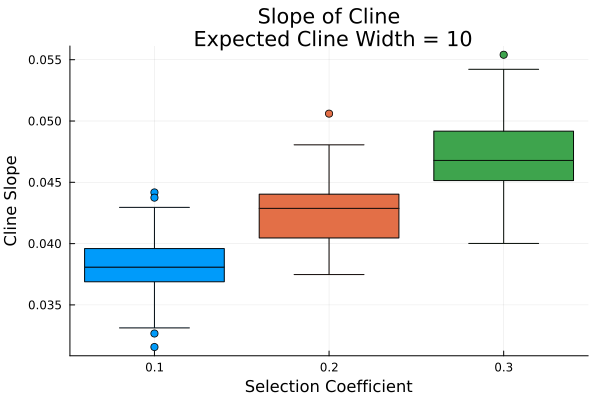

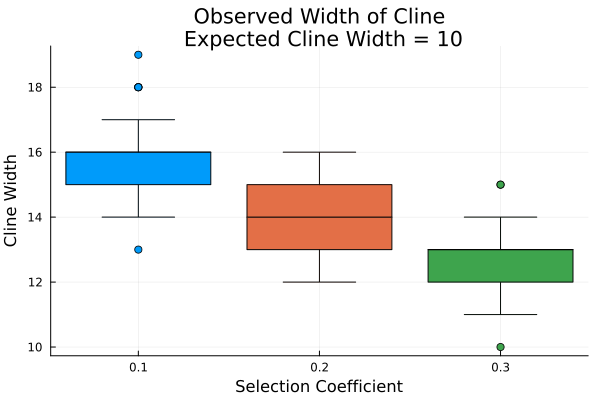

In [32]:
p1 = boxplot(slopes_by_s, 
             labels = "",
             ylabel = "Cline Slope",
             xlabel = "Selection Coefficient",
             title = "Slope of Cline\n Expected Cline Width = 10") |> 
             @λ xticks!(_,[1,2,3],string.(selection_coefficients))
display(p1)
             
p2 = boxplot(obs_cline_widths, 
             labels = "",
             ylabel = "Cline Width",
             xlabel = "Selection Coefficient",
             title = "Observed Width of Cline\n Expected Cline Width = 10") |> 
             @λ xticks!(_,[1,2,3],string.(selection_coefficients))



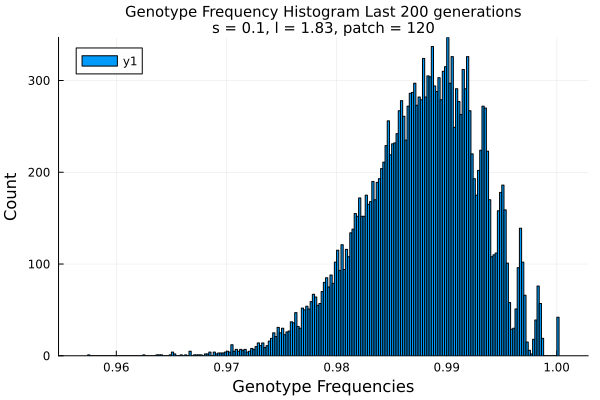

In [33]:

function genotype_histogram(cache, selection_coefficient, cline_width, patch)
    load_results!(cache, selection_coefficient, cline_width)
    allele_freqs = cache.genotype_frequencies[:,end-199:end,:,:,1] .+ cache.genotype_frequencies[:,end-199:end,:,:,2] .* 0.5
    dispersal_distance = sqrt(selection_coefficient/3)*cline_width
    histogram(reshape(mean.(eachslice(allele_freqs[:,:,patch, :],dims=(1,2))), (200*100)) ,
            bins=300,
            xlabel = "Genotype Frequencies",
            ylabel = "Count",
            title = "Genotype Frequency Histogram Last 200 generations\ns = $(selection_coefficient), l = $(round(dispersal_distance, digits=2)), patch = $patch",
            titlefont = 10)
end
genotype_histogram(cache, 0.1, 10., 120)


In [ ]:
load_results!(cache, 0.1, 10.)
allele_freqs = cache.genotype_frequencies[:,end-199:end,:,:,1] .+ cache.genotype_frequencies[:,end-199:end,:,:,2] .* 0.5 |>
                @λ reshape(mean.(eachslice(_[:,:,120, :],dims=(1,2))), (200*100))

BoundsError: BoundsError: attempt to access 100×300×5 Array{Float64, 3} at index [1:100, 1:300, 120, 1:1]

In [ ]:
allele_freqs = cache.genotype_frequencies[:,end,120,:,1] .+ cache.genotype_frequencies[:,end,120,:,2] .* 0.5 |> 
                    @λ mean.(eachrow(_))



100-element Vector{Float64}:
 0.9878618540242314
 0.9936507945880294
 0.9877886624075473
 0.980161358229816
 0.9909218543209135
 0.976724911481142
 0.9904481809586286
 0.9921854294836521
 0.9925183377228677
 0.9908453412353992
 ⋮
 0.995049224421382
 0.991993720177561
 0.9854139472357929
 0.9822933863848448
 0.9953702107071877
 0.9934535640291869
 0.9880495596677065
 0.9914524469524622
 0.9729506187140942

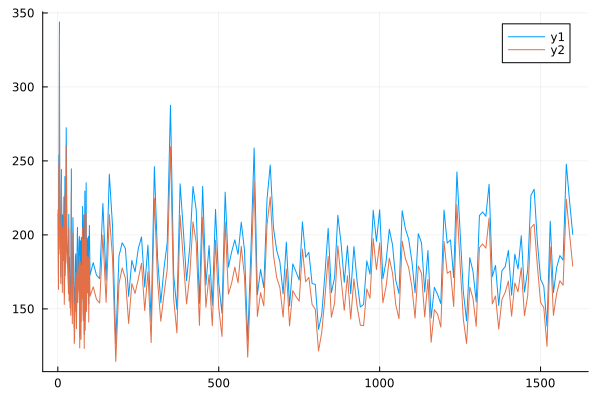

In [113]:
function fit_beta(index)

    allele_freqs = cache.genotype_frequencies[:,index,150,:,1] .+ cache.genotype_frequencies[:,index,150,:,2] .* 0.5 |> 
                   @λ mean.(eachrow(_))
    try 
        return [fit_mle(Beta,allele_freqs).α,fit_mle(Beta,allele_freqs).β]
    catch DomainError
        return [NaN,NaN]
    end
end

alphas = hcat(fit_beta.(1:1090)...)[1,:]
betas = hcat(fit_beta.(1:1090)...)[2,:]

t = vcat(1:100, 110:10:10000)
plot(t[1:250], alphas[1:250])
plot!(t[1:250], betas[1:250])


In [110]:
allele_freqs = cache.genotype_frequencies[:,1000,150,:,1] .+ cache.genotype_frequencies[:,1000,150,:,2] .* 0.5 |> 
                   @λ mean.(eachrow(_))
fit_mle(Beta,allele_freqs)

Beta{Float64}(α=187.98393782156768, β=170.5509914620409)

In [109]:
allele_freqs

100-element Vector{Float64}:
 0.9889856277033686
 0.9837698273360729
 0.9890581301413477
 0.9871644774451852
 0.9949074105359614
 0.9908044090494513
 0.9772661842405796
 0.9889653392136097
 0.9787241279147565
 0.9897003076970577
 ⋮
 0.9932660035789013
 0.991217372380197
 0.9982142874971032
 0.9854455348104239
 0.9786775289103389
 0.9858253697864712
 0.9949622932821512
 0.9827365723438561
 0.991511034220457

In [84]:
fit_mle(Beta,allele_freqs).α

395.35670183398537

In [58]:
all(isfinite.(allele_freqs))

true

In [34]:
using Distributions

In [65]:
fit_mle(Beta,allele_freqs)

Beta{Float64}(α=405.1060503136165, β=4.914372942674501)

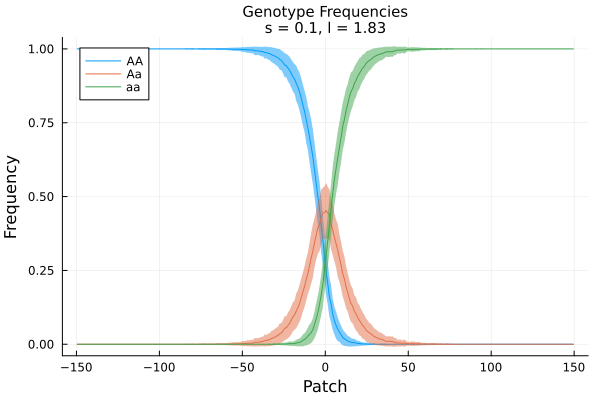

In [3]:
function plot_genotype_freqs!(cache, selection_coefficient, cline_width)
     load_results!(cache, selection_coefficient, cline_width)
     mean_freqs = mean.(eachslice(cache.genotype_frequencies[:,end,:,:,:,:],dims=(2,4)))
     std_freqs = std.(eachslice(cache.genotype_frequencies[:,end,:,:,:,:],dims=(2,4)))
     dispersal_distance = sqrt(selection_coefficient/3)*cline_width
     x = -149.5:149.5
     plot(x, mean_freqs,
          ribbon = std_freqs,
          label = ["AA" "Aa" "aa"],
          xlabel = "Patch",
          ylabel = "Frequency",
          title = "Genotype Frequencies\ns = $(selection_coefficient), l = $(round(dispersal_distance, digits=2))",
          titlefont = 10)
end
selection_coefficient, cline_width = 0.1, 10.
p = plot_genotype_freqs!(cache, selection_coefficient, cline_width)
savefig(p, "figures/genotype_freqs_s_$(selection_coefficient)_cw_$(cline_width).png")
p

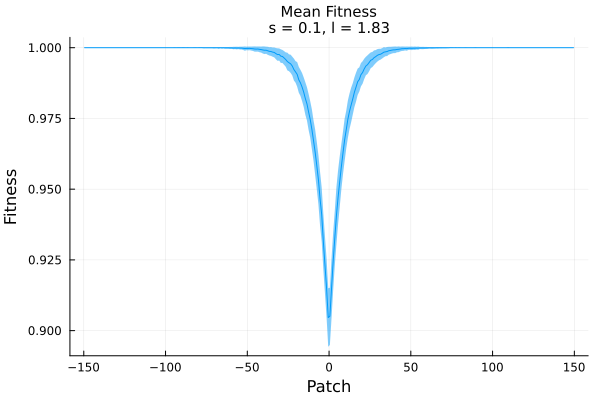

In [30]:
function plot_fitnesses!(cache, selection_coefficient, cline_width)
    load_results!(cache, selection_coefficient, cline_width)
    mean_fitnesses = mean.(eachslice(cache.fitnesses[:,end,:,:,:],dims=(2)))
    std_fitnesses = std.(eachslice(cache.fitnesses[:,end,:,:,:],dims=(2)))
    dispersal_distance = sqrt(selection_coefficient/3)*cline_width
    x = -149.5:149.5
    plot(x, mean_fitnesses,
        ribbon = std_fitnesses,
        xlabel = "Patch",
        ylabel = "Fitness",
        title = "Mean Fitness\ns = $selection_coefficient, l = $(round(dispersal_distance, digits=2))",
        label = "",
        titlefont = 10)
end
selection_coefficient, cline_width = 0.1, 10.
p = plot_fitnesses!(cache,selection_coefficient, cline_width)
savefig(p, "figures/mean_fitness_s_$(selection_coefficient)_cw_$(cline_width).png")
display(p)

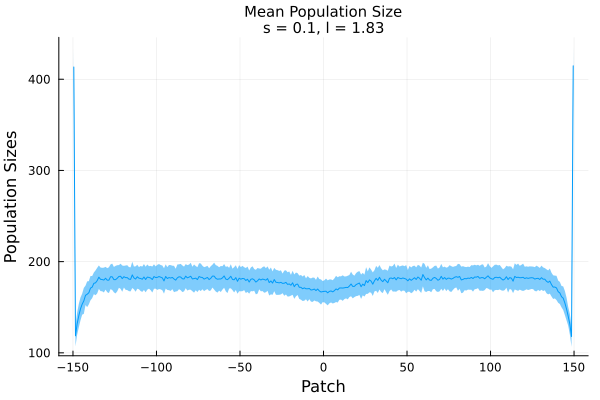

In [62]:
     
function plot_popsizes!(cache, selection_coefficient, cline_width)
     mean_popsizes = mean.(eachslice(sum.(eachslice(cache.population_sizes[:,end,:,3:5],dims = (1,2))),dims=(2)))
     std_popsizes = std.(eachslice(sum.(eachslice(cache.population_sizes[:,end,:,3:5],dims = (1,2))),dims=(2)))
     dispersal_distance = sqrt(selection_coefficient/3)*cline_width
     x = -149.5:149.5
     plot(x, mean_popsizes,
          ribbon = std_popsizes,
          xlabel = "Patch",
          ylabel = "Population Sizes",
          title = "Mean Population Size\ns = $selection_coefficient, l = $(round(dispersal_distance, digits=2))",
          label = "",
          titlefont = 10)
end
selection_coefficient, cline_width = 0.1, 10.
p = plot_popsizes!(cache, selection_coefficient, cline_width)
#ylims!(100,200)
savefig(p, "figures/mean_popsize_s_$(selection_coefficient)_cw_$(cline_width).png")
p

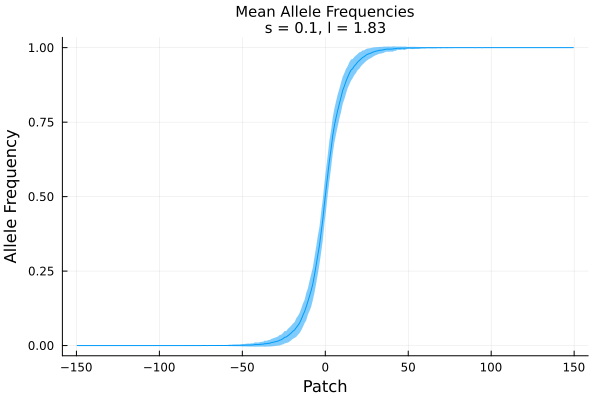

In [6]:

function plot_allele_freqs!(cache, selection_coefficient, cline_width)
     load_results!(cache, selection_coefficient, cline_width)

     allele_freqs = cache.genotype_frequencies[:,end,:,:,1] .+ cache.genotype_frequencies[:,end,:,:,2] .* 0.5
     mean_allele_freqs = mean.(eachslice(allele_freqs, dims = (2)))
     std_allele_freqs = std.(eachslice(allele_freqs, dims = (2)))
     dispersal_distance = sqrt(selection_coefficient/3)*cline_width
     x = -149.5:149.5
     plot(x, 1 .- mean_allele_freqs,
          ribbon = std_allele_freqs,
          xlabel = "Patch",
          ylabel = "Allele Frequency",
          title = "Mean Allele Frequencies\ns = $selection_coefficient, l = $(round(dispersal_distance, digits=2))",
          label = "",
          titlefont = 10)
end

selection_coefficient, cline_width = 0.1, 10.
p = plot_allele_freqs!(cache, selection_coefficient, cline_width)
savefig(p, "figures/mean_allele_freqs_s_$(selection_coefficient)_cw_$(cline_width).png")
p

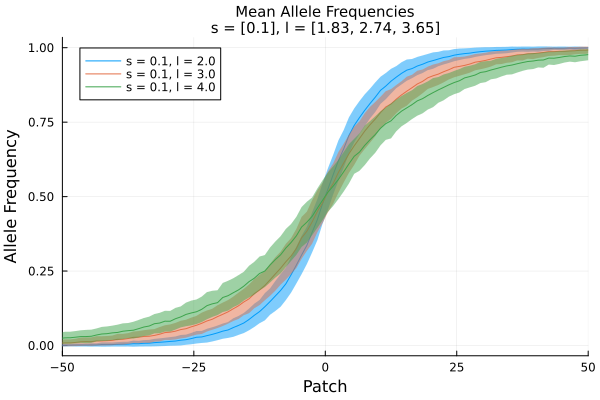

In [8]:

function plot_allele_freqs!(cache, selection_coefficients::Vector{Float64}, cline_widths::Vector{Float64})
    dispersal_distances = @. sqrt(selection_coefficients/3)*cline_widths
    x = -149.5:149.5
    p = plot(xlabel = "Patch",
             ylabel = "Allele Frequency",
             title = "Mean Allele Frequencies\ns = $selection_coefficients, l = $(round.(dispersal_distances, digits=2))",
             titlefont = 10)
    for selection_coefficient in selection_coefficients, cline_width in cline_widths
        load_results!(cache, selection_coefficient, cline_width)
        allele_freqs = cache.genotype_frequencies[:,end,:,:,3] .+ cache.genotype_frequencies[:,end,:,:,2] .* 0.5
        mean_allele_freqs = mean.(eachslice(allele_freqs, dims = (2)))
        std_allele_freqs = std.(eachslice(allele_freqs, dims = (2)))
        dispersal_distance = sqrt(selection_coefficient/3)*cline_width
    
        plot!(p, x, mean_allele_freqs,
              ribbon = std_allele_freqs,
              label = "s = $selection_coefficient, l = $(round(dispersal_distance))")
    end
    return p
end

selection_coefficients, cline_widths =[ 0.1], [10., 15.,20]
p = plot_allele_freqs!(cache, selection_coefficients, cline_widths)
xlims!(p, -50,50)
savefig(p, "figures/mean_allele_freqs_s_0.1_cw_multiple.png")
p

GKS: Number of points is invalid in routine FILLAREA
GKS: Number of points is invalid in routine FILLAREA
GKS: Number of points is invalid in routine FILLAREA
GKS: Number of points is invalid in routine FILLAREA
GKS: Number of points is invalid in routine FILLAREA
GKS: Number of points is invalid in routine FILLAREA
GKS: Number of points is invalid in routine FILLAREA
GKS: Number of points is invalid in routine FILLAREA


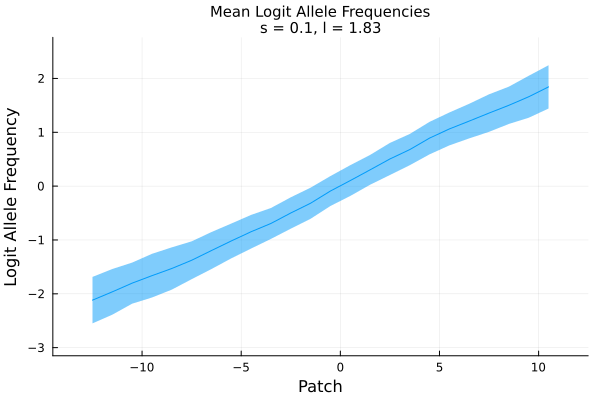

In [ ]:
logit(x) = log(x/(1-x))
function plot_logit_allele_freqs!(cache, selection_coefficient, cline_width)
    load_results!(cache, selection_coefficient, cline_width)
    
    logit_allele_freqs = logit.(cache.genotype_frequencies[:,end,:,:,3] .+ cache.genotype_frequencies[:,end,:,:,2] .* 0.5)
    mean_allele_freqs = mean.(eachslice(logit_allele_freqs, dims = (2)))
    std_allele_freqs = std.(eachslice(logit_allele_freqs, dims = (2)))
    dispersal_distance = sqrt(selection_coefficient/3)*cline_width
    x = -149.5:149.5
    xmin = x[findfirst(isfinite.(mean_allele_freqs))]
    xmax = x[findlast(isfinite.(mean_allele_freqs))]
    plot(x, mean_allele_freqs, 
         ribbon = std_allele_freqs,
         xlims = (xmin,xmax),
         xlabel = "Patch",
         ylabel = "Logit Allele Frequency",
         title = "Mean Logit Allele Frequencies\ns = $selection_coefficient, l = $(round(dispersal_distance, digits=2))",
         label = "",
         titlefont = 10 )
    
end
selection_coefficient, cline_width = 0.1, 10.
p = plot_logit_allele_freqs!(cache, selection_coefficient, cline_width)
savefig(p, "figures/mean_popsize_s_$(selection_coefficient)_cw_$(cline_width).png")
p

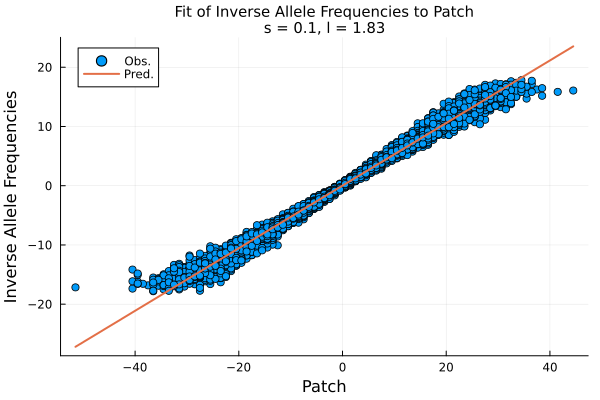

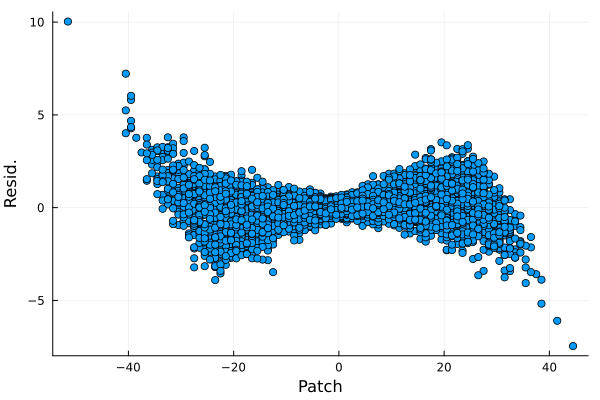

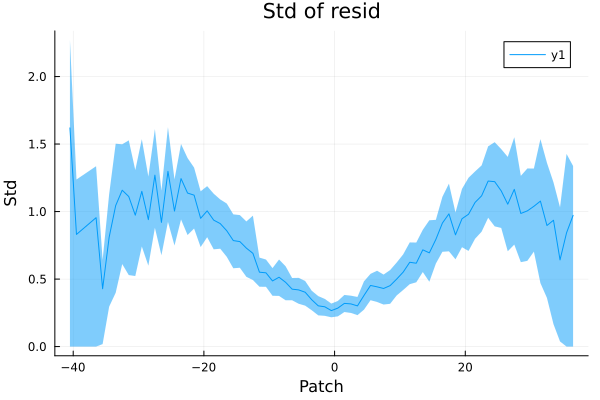

In [24]:
using DataFrames, GLM, StatsBase
function calc_inverse_allele_freqs(x,s,l)
    function f1(x) 
        try
            return (atanh(sqrt(2/3 * (x + 1/2))) - atanh(sqrt(2/3)))/sqrt(s/(2*l^2))
        catch DomainError
            return NaN
        end
    end
    f2(x) = -(atanh(sqrt(-2/3 * (x - 3/2))) - atanh(sqrt(2/3)))/sqrt(s/(2*l^2))

    if f1(x) > 0
        return f1(x)
    else
        return f2(x)
    end
end

function bootstrap(arr, n_samples, func = mean)
    [func(sample(arr, round(Int,length(arr)/2))) for i=1:n_samples]
end

function bootstraped_conf(means::Vector{Float64}, sig_level::Float64)
    if any(.~(isfinite.(means)))
        return (NaN,NaN)
    end
    return percentile(means, sig_level * 100), percentile(means, (1 -sig_level)*100)
end

function plot_inverse_allele_freqs!(cache, selection_coefficient, cline_width)
    load_results!(cache, selection_coefficient, cline_width)
    allele_freqs = cache.genotype_frequencies[:,end,:,:,3] .+ cache.genotype_frequencies[:,end,:,:,2] .* 0.5
    dispersal_distance = sqrt(selection_coefficient/3)*cline_width
    inverse_allele_freqs = calc_inverse_allele_freqs.(allele_freqs, selection_coefficient, dispersal_distance)
    y = reshape(mean.(eachslice(inverse_allele_freqs, dims = (1,2)))', (300*100)) 
    x = repeat(-149.5:149.5,100)
    df = DataFrame(X=x,Y=y)[isfinite.(y),:]


    scatter(df.X, df.Y)

    ols = lm(@formula(Y ~ X), df)
    p = scatter(df.X, df.Y, label = "Obs.")
    plot!(p, df.X, predict(ols), line = 2, label = "Pred.")
    xlabel!(p, "Patch")
    ylabel!(p, "Inverse Allele Frequencies")
    title!(p, "Fit of Inverse Allele Frequencies to Patch\ns = $selection_coefficient, l = $(round(dispersal_distance, digits=2))", titlefont = 10)
    
    resid = df.Y .- predict(ols)

    p_res = scatter(df.X,resid,
                    line = 2,
                    label ="",
                    ylabel = "Resid.",
                    xlabel = "Patch")

    confs = [bootstraped_conf(bootstrap(resid[df.X .== elem],1000, (x -> sqrt(var(x)))),0.01) for elem in unique(df.X)]
    min_conf = (x -> x[1]).(confs)
    max_conf = (x -> x[2]).(confs)
    var_resid = [sqrt(var(resid[df.X .== elem])) for elem in unique(df.X)]
    sorted_vars = (sort(collect(zip(unique(df.X),var_resid,min_conf,max_conf)); by=first) 
               |> filter((x -> ~any(isnan.(x)))))
    sorted_vars = (x -> vcat(x...)).(collect(zip(sorted_vars...)))
    p_res_var = plot(sorted_vars[1],
                     sorted_vars[2], 
                     ribbon = (abs.(sorted_vars[3] .- sorted_vars[2] ),abs.(sorted_vars[4] .- sorted_vars[2])),
                     title = "Std of resid",
                     xlabel = "Patch",
                     ylabel = "Std"
    )

    return p, p_res, p_res_var
end
p, p_res, p_res_var = plot_inverse_allele_freqs!(cache, 0.1, 10.)
display(p)
display(p_res)
display(p_res_var)

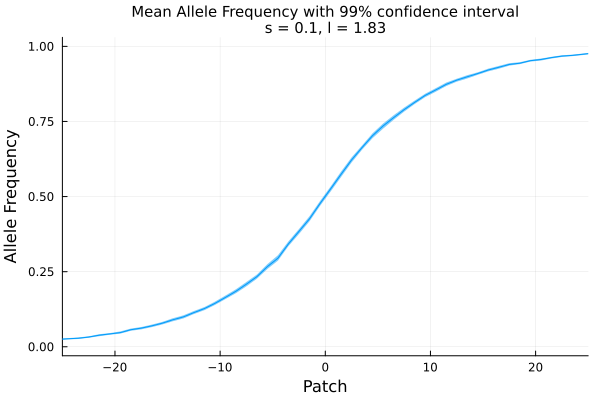

In [ ]:

function plot_allele_freqs_with_conf(cache, selection_coefficient, cline_width)
    load_results!(cache, selection_coefficient, cline_width)
    allele_freqs = cache.genotype_frequencies[:,end,:,:,3] .+ cache.genotype_frequencies[:,end,:,:,2] .* 0.5
    allele_freqs = mean.(eachslice(allele_freqs, dims = (1,2)))
    confs = bootstraped_conf.(bootstrap.(eachcol(allele_freqs),1000, mean),0.01)
    min_conf = (x -> x[1]).(confs)
    max_conf = (x -> x[2]).(confs)
    x = -149.5:149.5
    y = mean.(eachcol(allele_freqs))
    plot(x, y,
        ribbon = (abs.(y .- min_conf), abs.(y .-max_conf)),
        xlims= (-25,25),
        label="",
        xlabel="Patch",
        ylabel = "Allele Frequency",
        title="Mean Allele Frequency with 99% confidence interval\ns = $selection_coefficient, l = $(round(dispersal_distance, digits=2))", 
        titlefont = 10)
end

plot_allele_freqs_with_conf(cache, 0.1, 10.)

In [ ]:
allele_freqs = logit.(cache.genotype_frequencies[:,end,:,:,3] .+ cache.genotype_frequencies[:,end,:,:,2] .* 0.5)
allele_freqs = mean.(eachslice(allele_freqs, dims = (1,2)))
confs = bootstraped_conf.(bootstrap.(eachcol(allele_freqs),1000, var),0.01)
min_conf = (x -> x[1]).(confs)
max_conf = (x -> x[2]).(confs)
x = -149.5:149.5
y = var.(eachcol(allele_freqs))
plot(x, y,
     ribbon = (abs.(y .- min_conf), abs.(y .-max_conf)),
     xlims= (-25,25),
     label="",
     xlabel="Patch",
     ylabel = "Var. of Logit Allele Frequency",
     title="Var of Logit Allele Frequencies with 99% confidence interval\ns = $selection_coefficient, l = $(round(dispersal_distance, digits=2))", 
     titlefont = 10)

UndefVarError: UndefVarError: `logit` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: a global variable of this name may be made accessible by importing LogExpFunctions in the current active module Main
Hint: a global variable of this name may be made accessible by importing StatsFuns in the current active module Main

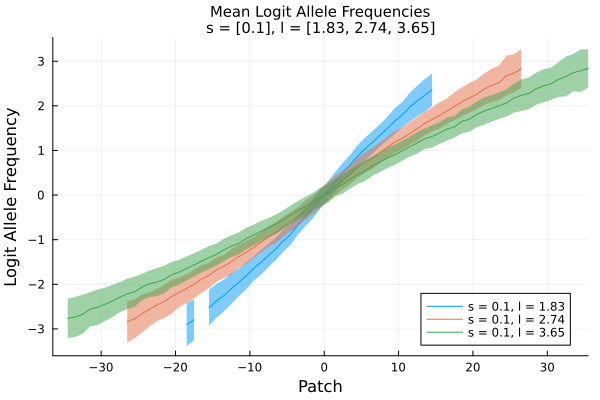

GKS: Number of points is invalid in routine FILLAREA
GKS: Number of points is invalid in routine FILLAREA
GKS: Number of points is invalid in routine FILLAREA
GKS: Number of points is invalid in routine FILLAREA
GKS: Number of points is invalid in routine FILLAREA
GKS: Number of points is invalid in routine FILLAREA
GKS: Number of points is invalid in routine FILLAREA
GKS: Number of points is invalid in routine FILLAREA


In [61]:
logit(x) = log(x/(1-x))
function plot_logit_allele_freqs!(cache, selection_coefficients::Vector{Float64}, cline_widths::Vector{Float64})
    x = -149.5:149.5
    dispersal_distances = @. sqrt(selection_coefficients/3)*cline_widths
    p = plot(xlabel = "Patch",
             ylabel = "Logit Allele Frequency",
             title = "Mean Logit Allele Frequencies\ns = $selection_coefficients, l = $(round.(dispersal_distances, digits=2))",
             titlefont = 10 )

    xmin = -1
    xmax = 1
    for selection_coefficient in selection_coefficients, cline_width in cline_widths 
        load_results!(cache, selection_coefficient, cline_width)

        logit_allele_freqs = logit.(cache.genotype_frequencies[:,end,:,:,3] .+ cache.genotype_frequencies[:,end,:,:,2] .* 0.5)
        mean_allele_freqs = mean.(eachslice(logit_allele_freqs, dims = (2)))
        std_allele_freqs = std.(eachslice(logit_allele_freqs, dims = (2)))
        dispersal_distance = sqrt(selection_coefficient/3)*cline_width

        current_xmin = x[findfirst(isfinite.(mean_allele_freqs))]
        current_xmax = x[findlast(isfinite.(mean_allele_freqs))]
        xmin = current_xmin  < xmin ? current_xmin : xmin
        xmax = current_xmax > xmin ? current_xmax : xmax

        plot!(p, x, mean_allele_freqs, 
              ribbon = std_allele_freqs,
              xlims = (xmin,xmax),
              label = "s = $selection_coefficient, l = $(round(dispersal_distance,digits=2))",
              )
    end
    xlims!(p, xmin, xmax)
    return p
    
end
p = plot_logit_allele_freqs!(cache, [0.1], [10., 15., 20.])
savefig(p, "figures/logit_allele_freqs_s_0.1_cw_multiple.png")
display(p)

In [39]:
cache.population_sizes[:,:,:,3:5]

100×1090×300×3 Array{Int16, 4}:
[:, :, 1, 1] =
 40  54  46  69  68  87  65  76  94  80  …   94   80   75   76   70   88   88
 40  53  50  66  62  77  63  67  66  72      76   74   84   85   84   90   88
 40  57  53  87  66  76  76  84  70  84      99   92   89   68   92   93   88
 40  57  65  68  75  72  78  80  80  66      78   90   85   91  116   93  106
 40  48  50  78  65  73  87  71  66  77      83  107   87   93   80   89   95
 40  54  57  77  78  62  89  80  85  91  …   85   82   93   86   85  104   93
 40  50  58  75  89  74  74  71  74  68      89   87   82   97   89   89   99
 40  52  49  81  58  65  87  85  82  69      79   71   90  115   74   85   78
 40  51  57  81  77  77  74  63  92  71      96  100   96   88   88  103   90
 40  50  66  69  75  76  79  78  75  72      95   77   71   80   85   93   82
  ⋮                   ⋮                  ⋱              ⋮                 
 40  46  56  78  72  70  75  94  76  71      76   95   82   84   77   89   68
 40  61  52  78  68 

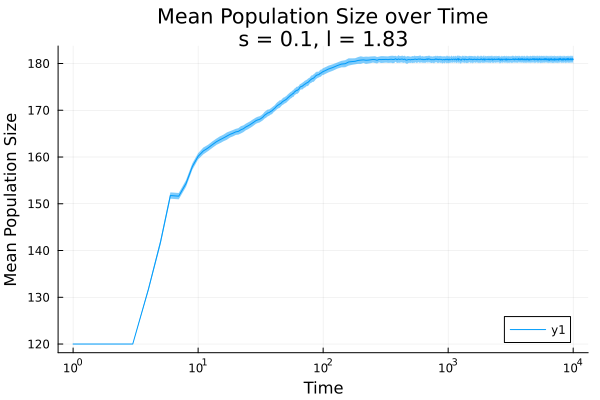

In [48]:
using LambdaFn
function plot_pop_vs_time!(cache,selection_coefficient, cline_width )
     load_results!(cache,selection_coefficient, cline_width)
     dispersal_distance = sqrt(selection_coefficient/3)*cline_width
     mean_popsize = sum.(eachslice(cache.population_sizes[:,:,:,3:5], dims=(1,2,3))) |> 
                         @λ mean.(eachslice(_, dims = (2)))
     std_popsize = sum.(eachslice(cache.population_sizes[:,:,:,3:5], dims=(1,2,3))) |> 
                         @λ mean.(eachslice(_, dims = (1,2))) |>
                         @λ std.(eachslice(_, dims = (2)))
     t = vcat(1:100, 110:10:10000)
     plot(t, mean_popsize,
          ribbon = std_popsize,
          #xscale = :log10,
          xlabel = "Time",
          ylabel = "Mean Population Size",
          title = "Mean Population Size over Time\ns = $selection_coefficient, l = $(round(dispersal_distance,digits=2))")
end
plot_pop_vs_time!(cache, 0.1, 10.)
plot!(xscale = :log10)
